#**SEP 775 Assignment - 2**
                        
**Student: Rutvik Roy**\
**Student ID: 400490159**


# Q-2 Seq2Seq Machine Translation with Attention


• Implement a sequence-to-sequence model with attention to perform machine translation
between two languages (e.g., English to French). This task will help you understand how conditioned
generation works in the context of translating sequences from one domain to another,
leveraging the power of LSTMs and attention mechanisms.

In [1]:
!pip install torch
!pip install torchtext
!pip install matplotlib
!pip install nltk
!pip install numpy

In [2]:
import torch
import torch.nn as nn
import requests
import re
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import torchtext
import string
from torch.nn.utils.rnn import pad_sequence
import nltk
nltk.download('wordnet')
from nltk.translate import meteor_score

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kenilsachapara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Load Data File

In [3]:
#text data from a file loaded on Google Drive

#file of 500 pairs
file_id='14FfLJXFfONnFlFcs9K8rtwoClhwzQzmF'
      
url= f"https://drive.google.com/uc?export=download&id={file_id}"

response=requests.get(url)
data=response.text

#Preprocess the data

In [4]:
###  data preprocessing steps ###

raw_data = data.split('\n')
pairs = [sentence.split('\t') for sentence in  raw_data]
pairs=pairs[:-2]
print(pairs[5])

def clean_sentence(sentence):

    # Lower case the sentence
    lower_case_sent = sentence.lower()

    # Strip punctuation
    string_punctuation = string.punctuation + "¡" + '¿'
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))

    return clean_sentence

def tokenize(sentences):

    # Create tokenizer
    text_tokenizer =torchtext.data.get_tokenizer("basic_english")

    tokenized_sentences=[text_tokenizer(sent) for sent in sentences]
    return tokenized_sentences


['Hello!', 'नमस्कार।']


In [5]:
# Clean sentences
english_sentences = [clean_sentence(pair[0]) for pair in pairs]
hindi_sentences = [clean_sentence(pair[1]) for pair in pairs]


# Tokenize words
hindi_text_tokenized= tokenize(hindi_sentences)
english_text_tokenized= tokenize(english_sentences)

print('Maximum length of hindi sentence: {}'.format(len(max(hindi_text_tokenized,key=len))))
print('Maximum length of english sentence: {}'.format(len(max(english_text_tokenized,key=len))))
print("\n")

# Check language length
hindi_vocab = list(set([word for word_list in hindi_text_tokenized for word in word_list]))
english_vocab = list(set([word for word_list in english_text_tokenized for word in word_list]))

print("hindi vocabulary is of {} unique words".format(len(hindi_vocab)))
print("English vocabulary is of {} unique words".format(len(english_vocab)))

Maximum length of hindi sentence: 8
Maximum length of english sentence: 5


hindi vocabulary is of 358 unique words
English vocabulary is of 245 unique words


In [6]:
#add pad token into hindi vocabulary

hindi_vocab.insert(0,'<pad>')
hindi_vocab.insert(1,'<SOS>')
hindi_vocab.insert(2,'<EOS>')
english_vocab.insert(0,'<pad>')
print(hindi_vocab)

['<pad>', '<SOS>', '<EOS>', 'नसीब', 'उसने', 'से', 'बरफ़', 'व्यस्थ', 'मोटे', 'बोर', 'कहाँ', 'सही', 'आने', 'आईए।', 'सकते', 'ताकतवर', 'पागल', 'वहाँ', 'हिलो', 'कितने', 'ग़लत', 'मज़े', 'गरम', 'उसको', 'करते', 'चुका', 'टोपी', 'रसोइया', 'स्वागतम्।', 'साथ', 'भूख', 'मत।', 'गया', 'तुमसे', 'आओ।', 'याद', 'बधाईयाँ।', 'पढ़ाई', 'ख़ुदा', 'अपने', 'लगते', 'भर', 'कोशिश', 'साल', 'मान', 'इतिहास', 'ख़ूब', 'ज़रूरत', 'खोलो।', 'दौड़ने', 'सकता।', 'पढ़', 'नमस्ते।', 'दिखाओ।', 'तैरना', 'जाना', 'पकाया।', 'थक', 'चुकीं', 'आपको', 'होगा।', 'भूल', 'खिलते', 'रहा', 'खुश', 'ट्राए', 'तैर', 'आसपास', 'उड़ाएँ', 'हँसा।', 'हूँ', 'सहायता', 'का', 'बावर्ची', 'लेलूँगा।', 'आपकी', 'कैसा', 'पेट', 'आवाज़', 'करूँगा।', 'हमारे', 'हर', 'हो', 'गाड़ी', 'शहर', 'भागते', 'चाल', 'लेकिन', 'देखा।', 'पता', 'अविश्वसनीय', 'कोई', 'सुनाई', 'बनो।', 'हुए', 'खोलिए।', 'मरा', 'हार', 'कि', 'रहे', 'है', 'पसंद', 'ठंड', 'अब', 'लगता', 'एक', 'को', 'अद्भुत', 'गया।', 'बात', 'नव', 'सकतीं', 'वाहवाह', 'काला', 'रोज़', 'चिल्लाईए', 'पर', 'देखने', 'मुफ़्त', 'नए', 'वैसा', 'प

In [7]:
#vocab building

hindi_vocab_size=len(hindi_vocab)
english_vocab_size=len(english_vocab)

hindi_word_to_index={word:i for i,word in enumerate(hindi_vocab)}
hindi_index_to_word={i:word for i,word in enumerate(hindi_vocab)}


english_word_to_index={word:i for i,word in enumerate(english_vocab)}
english_index_to_word={i:word for i,word in enumerate(english_vocab)}


In [8]:
#pad sentences

pad_token='<pad>'
def pad_sents(sents, pad_token):

    sents_padded = []
    sents=sents
    max_length = max(len(sent) for sent in sents)
    print(max_length)

    # Pad each sentence to match the max length
    sents_padded = [sent + [pad_token] * (max_length - len(sent)) for sent in sents]

    return sents_padded

padded_english_sent=pad_sents(english_text_tokenized,pad_token)
padded_hindi_sent=pad_sents(hindi_text_tokenized,pad_token)
print(padded_hindi_sent)
print(padded_english_sent)

5
8
[['बचाओ', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['उछलो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['कूदो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['छलांग', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['नमस्ते।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['नमस्कार।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['वाहवाह', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['चियर्स', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['समझे', 'कि', 'नहीं', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['मैं', 'ठीक', 'हूँ।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['बहुत', 'बढ़िया', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['अंदर', 'आ', 'जाओ।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['बाहर', 'निकल', 'जाओ', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['चले', 'जाओ', '<pad>', '<pad>', '<pad>', '<pad>'

In [9]:
def add_start(sent):
  return ['<SOS>']+sent

def add_stop(sent):
  return sent+['<EOS>']

# **(1) Seq2Seq Model without Attention**

In [9]:

class Encoder1(nn.Module):
    def __init__(self,english_vocab_size,embedding_d,input_size,hidden_size,num_layers):
        super().__init__()

        #embedding and LSTM layer
        self.embedding1= nn.Embedding(english_vocab_size,embedding_d)
        self.dropout1 = nn.Dropout(p=0.3)
        self.rnn1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self,encoder_input):

      indexs=[english_word_to_index[w] for w in encoder_input]
      embed=self.embedding1(torch.tensor(indexs))
      em = self.dropout1(embed)
      encoder_output, (encoder_hidden,encoder_cell) = self.rnn1(em)
      return encoder_output, (encoder_hidden,encoder_cell)


class Decoder1(nn.Module):
    def __init__(self,hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size):
        super().__init__()

        #embedding and LSTM layer
        self.embedding2=nn.Embedding(hindi_vocab_size, embedding_d)
        self.rnn2 = nn.LSTM(input_size, hidden_size,num_layers,batch_first=True)
        self.fc2 = nn.Linear(hidden_size , output_size)

    def forward(self, decoder_input, encoder_hidden,encoder_cell):

        indexs=[hindi_word_to_index[w] for w in decoder_input]
        input=self.embedding2(torch.tensor(indexs))
        decoder_output, (decoder_hidden,deocder_cell) = self.rnn2(input,(encoder_hidden,encoder_cell))

        out = self.fc2(decoder_output)
        return out

#Create a model

In [10]:
hindi_vocab_size,english_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size=hindi_vocab_size,english_vocab_size,90,90,128,2,hindi_vocab_size

encoder1 = Encoder1(english_vocab_size,embedding_d,input_size,hidden_size,num_layers)
decoder1 = Decoder1(hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size)
loss_fun1 = torch.nn.CrossEntropyLoss()
encoder1_optimizer = optim.Adagrad(encoder1.parameters(), lr=0.01)
decoder1_optimizer = optim.Adagrad(decoder1.parameters(), lr=0.01)

#a summary of the model parameters
total_params = sum(param.numel() for param in encoder1.parameters())
print(f"Total trainable parameters in the Encoder model: {total_params}")

total_params = sum(param.numel() for param in decoder1.parameters())
print(f"Total trainable parameters in the Decoder model: {total_params}")

Total trainable parameters in the Encoder model: 266876
Total trainable parameters in the Decoder model: 323795


#Train Model

In [11]:
# train the model

num_epochs = 250
LOSS1=[]

for epoch in range(num_epochs):
  running_loss1=0
  for i in range(len(pairs)):

    #encoder input sentence
    e_input=padded_english_sent[i]

    #decoder input sentence
    d_input=padded_hindi_sent[i]
    d_input=add_start(d_input)

    #decoder target sentence
    d_target=padded_hindi_sent[i]
    d_target=add_stop(d_target)

    encoder1_o, (encoder1_h,encoder1_c) = encoder1(e_input)
    out1 = decoder1(d_input,encoder1_h,encoder1_c)

    #one hot vector of decoder target to measure cross entropy loss
    a1=nn.functional.one_hot(torch.tensor([hindi_word_to_index[token] for token in d_target]),hindi_vocab_size).type('torch.FloatTensor')

    encoder1_optimizer.zero_grad()
    decoder1_optimizer.zero_grad()

    loss1 = loss_fun1(out1, a1)
    loss1.backward(retain_graph=True)

    encoder1_optimizer.step()
    decoder1_optimizer.step()

    running_loss1+=loss1

  LOSS1.append(running_loss1 / len(pairs))
  #print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss / len(pairs)))

Text(0.5, 1.0, 'Seq2Seq without Attention')

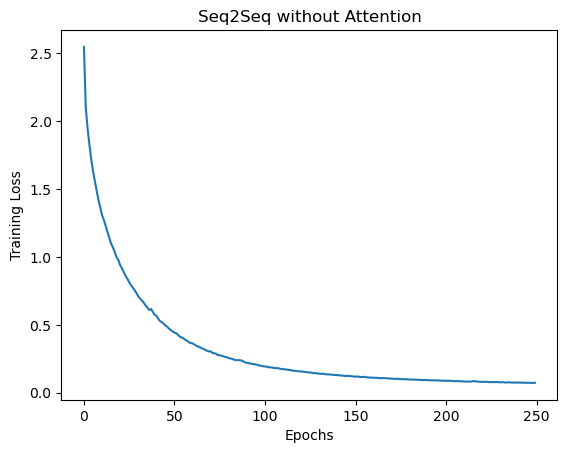

In [12]:
#Plot loss
plt.plot([i for i in range(num_epochs)],[loss.detach().numpy() for loss in LOSS1])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Seq2Seq without Attention")

#Save Model

In [13]:
#save model (remove # comment to overwrite or save new weight)
#torch.save(encoder1.state_dict(), 'encoder_model_without_atten_weights.pth')
#torch.save(decoder1.state_dict(), 'decoder_model_without_atten_weights.pth')

In [14]:
#torch.save(encoder1.state_dict(), 'encoder_model_without_atten_weights.pt')
#torch.save(decoder1.state_dict(), 'decoder_model_without_atten_weights.pt')

#torch.save(encoder1.state_dict(), 'encoder_model_without_atten_weights.h5')
#torch.save(decoder1.state_dict(), 'decoder_model_without_atten_weights.h5')

#Test Model

In [15]:
# Load the saved model
hindi_vocab_size,english_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size=hindi_vocab_size,english_vocab_size,90,90,128,2,hindi_vocab_size
loaded_encoder_model1=Encoder1(english_vocab_size,embedding_d,input_size,hidden_size,num_layers)
loaded_encoder_model1.load_state_dict(torch.load('encoder_model_without_atten_weights.pth'))
loaded_encoder_model1.eval()

loaded_decoder_model1=Decoder1(hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size)
loaded_decoder_model1.load_state_dict(torch.load('decoder_model_without_atten_weights.pth'))
loaded_decoder_model1.eval()

Decoder1(
  (embedding2): Embedding(361, 90)
  (rnn2): LSTM(90, 128, num_layers=2, batch_first=True)
  (fc2): Linear(in_features=128, out_features=361, bias=True)
)

In [16]:
#input english sentence from training set for "prediction"

number_of_sentences = 10
candidate_corpus1=[]
references_corpus1 =[]

for i in range(number_of_sentences):

  #encoder input sentence
  encoder_input=padded_english_sent[i]

  #decoder targe for blue score measurement
  decoder_target=padded_hindi_sent[i]

  o,(h,c)=loaded_encoder_model1(encoder_input)
  e_h=h
  e_c=c

  #first word to be feeded into decoder
  decoder_input1=["<pad>"]

  #list of predicted words
  word1=[]

  for i in range(len(max(hindi_text_tokenized,key=len))):

    # Make predictions
    with torch.no_grad():

        ##pass decoder_input1 list to decoder
        out1=loaded_decoder_model1(decoder_input1,e_h,e_c)
        soft=nn.Softmax(dim=0)
        out1=soft(out1[-1])

        #take the highest probable one
        out1=torch.argmax(out1)
        predicted_word=hindi_index_to_word[out1.item()]

        #append the predicted word in the list
        word1.append(predicted_word)
        decoder_input1.append(predicted_word)

  # removed last word from hindi setenced beciase pytorch blue_score function can measure it upto 4-gram only
  candidate_corpus1.append(word1[:-1])
  references_corpus1.append([decoder_target[:]])

  print("Encoder Input:",encoder_input)
  print("Decoder output:",' '.join(word1[:]))
  print("\n")

Encoder Input: ['help', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['hello', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['hello', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['cheers', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['cheers', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: <pad> <pad> <pad> <pad> <pad> <pad> 

#Model Evaluation (BLUE and METEOR Score)

In [17]:
nltk.download('omw-1.4')

print("candidate_corpus:",candidate_corpus1)
print("references_corpus:",references_corpus1)
print("\n")

# Convert the corpora to strings
candidate_strings1 = [' '.join(sent) for sent in candidate_corpus1]
reference_strings1 = [[' '.join(ref[0])] for ref in references_corpus1]

# Calculate METEOR score
meteor_score_value = meteor_score.meteor_score(reference_strings1, candidate_strings1)

print("Blue Score of Seq2Seq Model without attention:",torchtext.data.metrics.bleu_score(candidate_corpus1,references_corpus1))
print("METEOR Score of Seq2Seq Model without attention:", meteor_score_value)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kenilsachapara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


candidate_corpus: [['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['समझे', 'समझे', 'कि', 'नहीं', '<pad>', '<pad>', '<pad>'], ['मैं', 'ठीक', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
references_corpus: [[['बचाओ', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['उछलो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['कूदो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['छलांग', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['नमस्ते।', '<pad>'

# **(2) Seq2Seq Model with Attention**

In [10]:

class Encoder(nn.Module):
    def __init__(self,english_vocab_size,embedding_d,input_size,hidden_size,num_layers):
        super().__init__()
        self.embedding3= nn.Embedding(english_vocab_size,embedding_d)
        self.dropout3 = nn.Dropout(p=0.3)
        self.rnn3 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self,encoder_input):

      indexs=[english_word_to_index[w] for w in encoder_input]
      embd=self.embedding3(torch.tensor(indexs))
      e = self.dropout3(embd)
      encoder_output, (encoder_hidden,encoder_cell) = self.rnn3(e)
      return encoder_output, (encoder_hidden,encoder_cell)


class Decoder(nn.Module):
    def __init__(self,hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size):
        super().__init__()

        #embedding and LSTM layer
        self.embedding4=nn.Embedding(hindi_vocab_size, embedding_d)
        self.rnn4 = nn.LSTM(input_size, hidden_size,num_layers,batch_first=True)
        self.fc4 = nn.Linear(hidden_size + hidden_size, output_size)


    def forward(self, decoder_input, encoder_hidden,encoder_cell,encoder_output):

        indexs=[hindi_word_to_index[w] for w in decoder_input]
        input=self.embedding4(torch.tensor(indexs))
        decoder_output, (decoder_hidden,deocder_cell) = self.rnn4(input,(encoder_hidden,encoder_cell))

        ##   attention score ##
        attn_scores = torch.matmul(decoder_output, encoder_output.T)
        attn_weights = torch.nn.functional.softmax(attn_scores, dim=1)
        context_vector = torch.matmul(attn_weights.unsqueeze(1), encoder_output).squeeze(1)
        combined_input = torch.cat((decoder_output, context_vector), dim=1)

        out = self.fc4(combined_input)
        return out,attn_weights

#Create a model

In [11]:
hindi_vocab_size,english_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size=hindi_vocab_size,english_vocab_size,90,90,128,2,hindi_vocab_size

#create oobject of class (encoder-decoder model with attention)
encoder = Encoder(english_vocab_size,embedding_d,input_size,hidden_size,num_layers)
decoder = Decoder(hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size)
loss_fun = torch.nn.CrossEntropyLoss()
encoder_optimizer = optim.Adagrad(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adagrad(decoder.parameters(), lr=0.01)

#a summary of the model parameters
total_params = sum(param.numel() for param in encoder.parameters())
print(f"Total trainable parameters in the Encoder model: {total_params}")

total_params = sum(param.numel() for param in decoder.parameters())
print(f"Total trainable parameters in the Decoder model: {total_params}")

Total trainable parameters in the Encoder model: 266876
Total trainable parameters in the Decoder model: 370003


#Train Model

In [12]:
# train the model

num_epochs = 250
LOSS=[]

for epoch in range(num_epochs):
  running_loss=0
  for i in range(len(pairs)):

    #encoder input sentence
    e_input=padded_english_sent[i]

    #decoder input sentence
    d_input=padded_hindi_sent[i]
    d_input=add_start(d_input)

    #decoder target sentence
    d_target=padded_hindi_sent[i]
    d_target=add_stop(d_target)

    encoder_o, (encoder_h,encoder_c) = encoder(e_input)
    out,attention_weights = decoder(d_input,encoder_h,encoder_c,encoder_o)

    #one hot vector of decoder target to measure cross entropy loss
    a=nn.functional.one_hot(torch.tensor([hindi_word_to_index[token] for token in d_target]),hindi_vocab_size).type('torch.FloatTensor')

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    #loss
    loss = loss_fun(out, a)
    loss.backward(retain_graph=True)

    encoder_optimizer.step()
    decoder_optimizer.step()

    running_loss+=loss

  LOSS.append(running_loss / len(pairs))
  #print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss / len(pairs)))

Text(0.5, 1.0, 'Seq2Seq with Attention')

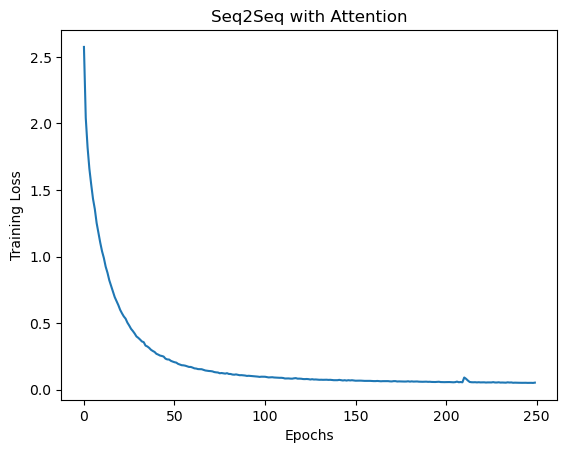

In [13]:
#Plot loss

plt.plot([i for i in range(num_epochs)],[loss.detach().numpy() for loss in LOSS])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Seq2Seq with Attention")

#Save Model

In [14]:
#save model (remove # comment to overwrite or save new weight)

#torch.save(encoder.state_dict(), 'encoder_model_with_atten_weights.pth')
#torch.save(decoder.state_dict(), 'decoder_model_with_atten_weights.pth')

In [15]:
#torch.save(encoder.state_dict(), 'encoder_model_with_atten_weights.pt')
#torch.save(decoder.state_dict(), 'decoder_model_with_atten_weights.pt')

#torch.save(encoder.state_dict(), 'encoder_model_with_atten_weights.h5')
#torch.save(decoder.state_dict(), 'decoder_model_with_atten_weights.h5')

#Test Model

In [16]:
# Load the saved model

hindi_vocab_size,english_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size=hindi_vocab_size,english_vocab_size,90,90,128,2,hindi_vocab_size
loaded_encoder_model=Encoder(english_vocab_size,embedding_d,input_size,hidden_size,num_layers)
loaded_encoder_model.load_state_dict(torch.load('encoder_model_with_atten_weights.pth'))
loaded_encoder_model.eval()

loaded_decoder_model=Decoder(hindi_vocab_size,embedding_d,input_size,hidden_size,num_layers,output_size)
loaded_decoder_model.load_state_dict(torch.load('decoder_model_with_atten_weights.pth'))
loaded_decoder_model.eval()

Decoder(
  (embedding4): Embedding(361, 90)
  (rnn4): LSTM(90, 128, num_layers=2, batch_first=True)
  (fc4): Linear(in_features=256, out_features=361, bias=True)
)

In [17]:
#input english sentences from training set for prediction

number_of_sentences = 10
candidate_corpus=[]
references_corpus=[]

for i in range(number_of_sentences):

  #encoder input sentence
  encoder_input=padded_english_sent[i]

  #decoder targe for blue score measurement
  decoder_target=padded_hindi_sent[i]


  #pass encoder input (Englsih sentence) to encoder
  o,(h,c)=loaded_encoder_model(encoder_input)

  e_o=o
  e_h=h
  e_c=c

  #first word to be feeded into decoder
  decoder_input=['<SOS>']

  #list of predicted words
  word=[]

  for i in range(len(max(hindi_text_tokenized,key=len))+1):

    # Make predictions
    with torch.no_grad():

        ##pass decoder_input list to decoder
        out,attention_weights=loaded_decoder_model(decoder_input,e_h,e_c,e_o)

        soft=nn.Softmax(dim=0)
        out=soft(out[-1])

        #take the highest probable one
        out=torch.argmax(out)
        predicted_word=hindi_index_to_word[out.item()]

        #append the predicted word in the list to feed again to decoder
        word.append(predicted_word)
        decoder_input.append(predicted_word)


  # removed last word from hindi setence
  candidate_corpus.append(word[:-1])
  references_corpus.append([decoder_target[:]])

  print("Encoder Input:",encoder_input)
  print("Decoder output:",' '.join(word[:]))
  print("\n")

Encoder Input: ['help', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: बचाओ <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: छलांग <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: छलांग <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['jump', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: छलांग <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['hello', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: नमस्कार। <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['hello', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: नमस्कार। <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['cheers', '<pad>', '<pad>', '<pad>', '<pad>']
Decoder output: चियर्स <pad> <pad> <pad> <pad> <pad> <pad> <pad> <EOS>


Encoder Input: ['cheers', '<pad>', '<pad>', '<pad>', '<pad>']
Deco

#Model Evaluation (BLUE and METEOR Score)

In [18]:
print("candidate_corpus:",candidate_corpus)
print("references_corpus:",references_corpus)
print("\n")

# Convert the corpora to strings
candidate_strings = [' '.join(sent) for sent in candidate_corpus]
reference_strings = [[' '.join(ref[0])] for ref in references_corpus]

# Calculate METEOR score
meteor_score_value = meteor_score.meteor_score(reference_strings, candidate_strings)

print("Blue Score of Seq2Seq Model with attention:",torchtext.data.metrics.bleu_score(candidate_corpus,references_corpus))
print("METEOR Score of Seq2Seq Model with attention:", meteor_score_value)

candidate_corpus: [['बचाओ', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['छलांग', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['छलांग', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['छलांग', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['नमस्कार।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['नमस्कार।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['चियर्स', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['चियर्स', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['समझे', 'कि', 'नहीं', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['मैं', 'ठीक', 'हूँ।', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]
references_corpus: [[['बचाओ', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['उछलो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']], [['कूदो', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']],

#Attention Heatmap

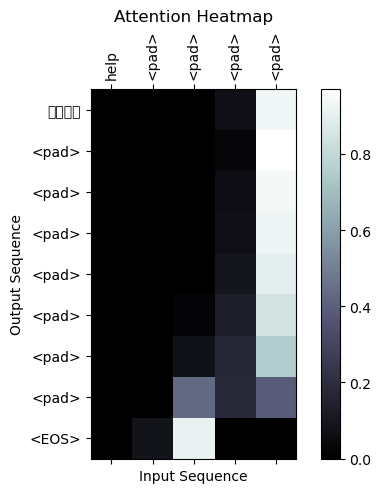

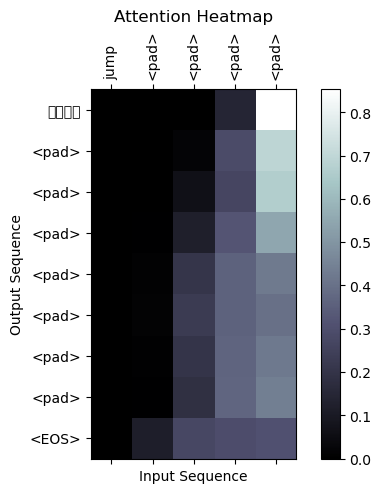

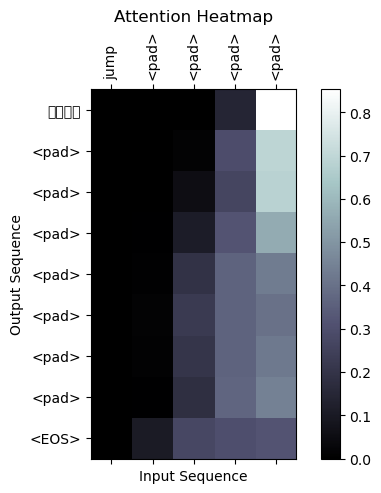

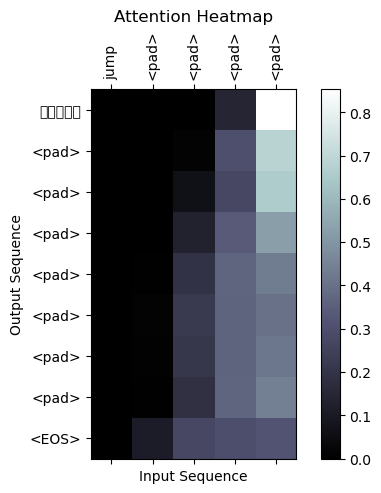

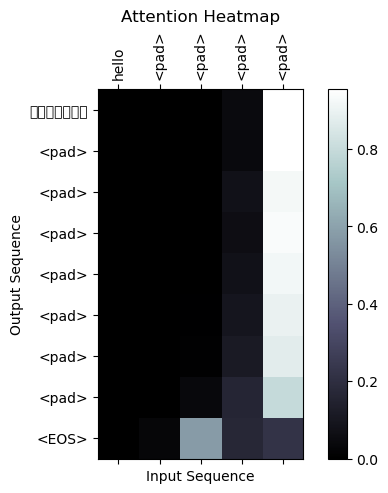

In [20]:
#attention heat map

import matplotlib.ticker as ticker
def plot_attention(attention_weights, input_sequence, output_sequence):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention_weights.numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticks(range(len(input_sequence) ))
    ax.set_yticks(range(len(output_sequence)+1))

    ax.set_xticklabels(input_sequence, rotation=90)
    ax.set_yticklabels(output_sequence+['<EOS>'])

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.title('Attention Heatmap')

    plt.show()


number_of_sentences = 5

for i in range(number_of_sentences):

  #encoder input sentence
  encoder_input=padded_english_sent[i]

  decoder_target=padded_hindi_sent[i]

  #decoder input
  d_input=padded_hindi_sent[i]
  d_input=add_start(d_input)

  #pass encoder input (Englsih sentence) to encoder
  o,(h,c)=loaded_encoder_model(encoder_input)

  # Make predictions
  with torch.no_grad():

  ##pass decoder_input list to decoder
    out,attention_weights=loaded_decoder_model(d_input,h,c,o)

  plot_attention(attention_weights, encoder_input, decoder_target)
